# Lettura dati

In [8]:
import csv
import qutip
import numpy as np
import scipy.optimize as opt
from scipy.spatial.transform import Rotation as R
from scipy.signal import lombscargle
import matplotlib.pyplot as plt
import math



def plain(xy, a, b, d):
    x, y = xy
    return a*x + b*y +d #z = a*x + b*y +d

bloch= qutip.Bloch()
field = ["Ch", "Time", "Theta", "Eta", "DOP", "Power", "S1", "S2", "S3"]

data = np.empty((4, 4), dtype=object)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data[i, j] = []

with open("csv/freq_2025-04-14_09-16.csv", mode="r", newline="") as file:
    rdr = csv.DictReader(file)
    rdr.fieldnames = field
    for i in range(1,5):
        file.seek(0)
        for row in rdr:
            if(row["Ch"]==str(i)):
                if len(data[i-1,0]) and float(row["S1"]) == data[i-1,0][-1] and float(row["S2"]) == data[i-1,1][-1] and float(row["S3"]) == data[i-1,2][-1]: # non prendo dati consecutivi uguali
                    continue
                data[i-1,0].append(float(row["S1"]))
                data[i-1,1].append(float(row["S2"]))
                data[i-1,2].append(float(row["S3"]))
                data[i-1,3].append(float(row["Time"]))
        

### Fit con piano

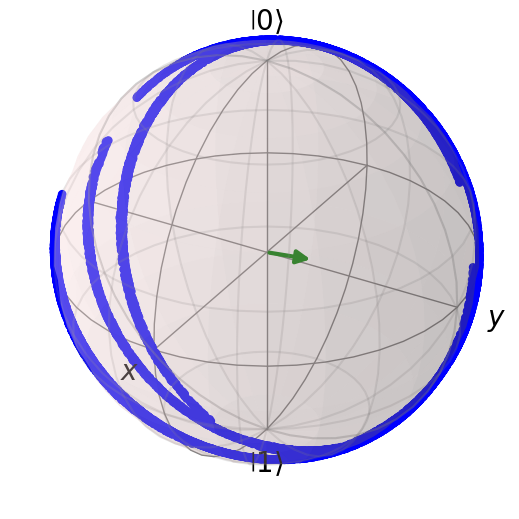

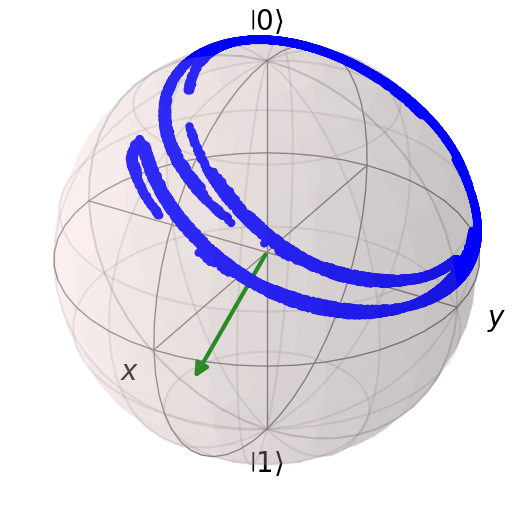

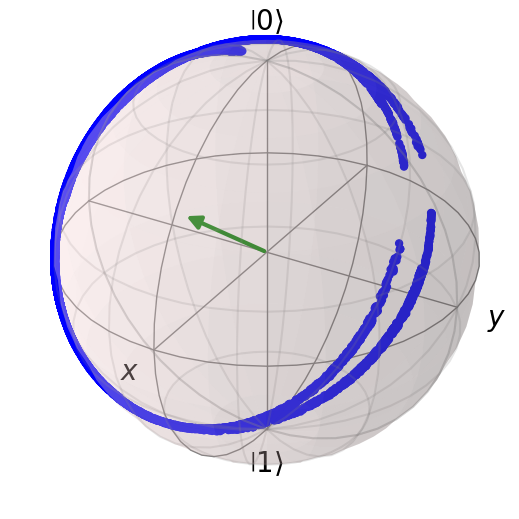

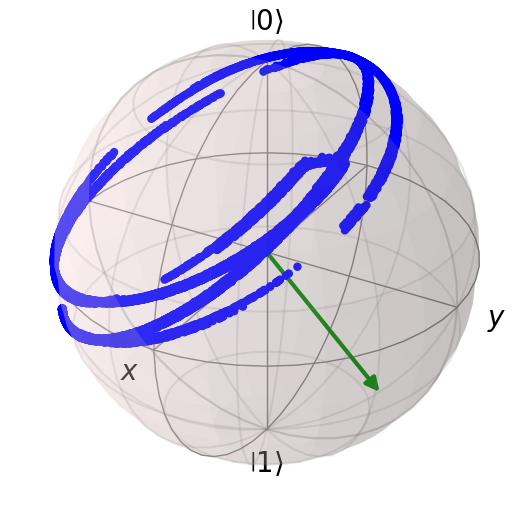

In [9]:

vect = np.empty((4,3))

for i in range(4):
    bloch.clear()
    bloch.add_points([data[i,0], data[i,1], data[i,2]])
    # Fit the data to a plane
    parameters, covariance = opt.curve_fit(plain, (data[i,0],data[i,1]), data[i,2])
    a, b, _= parameters
    vect_t = [a, b, -1]
    vect[i] = vect_t/np.linalg.norm(vect_t)
    bloch.add_vectors(vect[i])
    bloch.show()
    

### Rotazione del piano

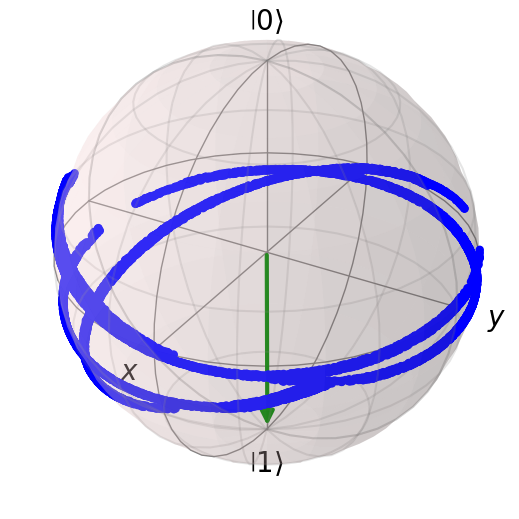

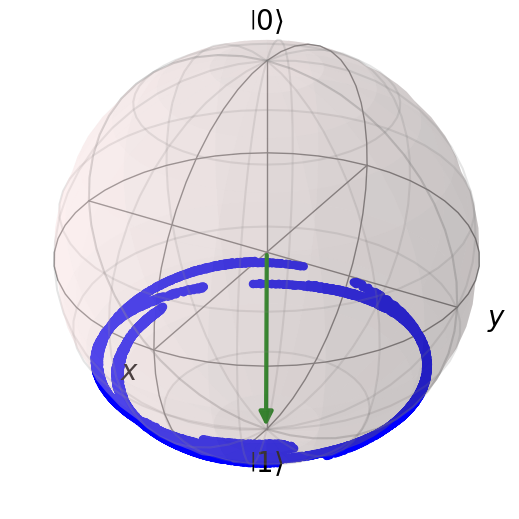

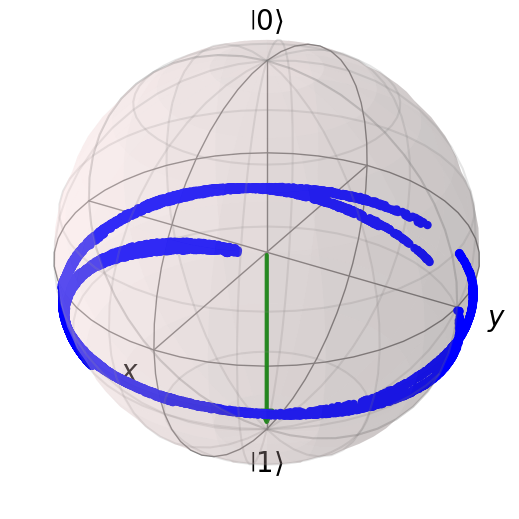

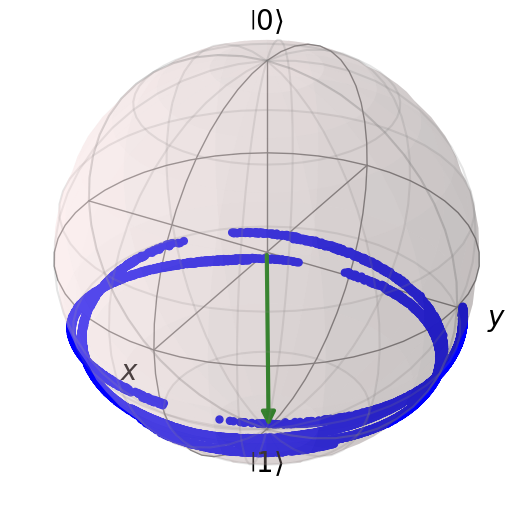

In [10]:
for i in range(4):
    d = 1
    while d>0.01:
        # Rotate the data to align with the z-axis
        rot_vect = np.cross([0,0,1], vect[i])
        rot_vect = rot_vect/np.linalg.norm(rot_vect)
        angle = -np.arccos(np.dot([0,0,1], vect[i]))
        rot = R.from_rotvec(angle*rot_vect)
        bloch.clear()
        for j in range(len(data[i,0])):
            new_point = rot.apply([data[i,0][j], data[i,1][j], data[i,2][j]])
            #print(new_point)
            data[i,0][j]=new_point[0]
            data[i,1][j]=new_point[1]
            data[i,2][j]=new_point[2]
        # Display new vector
        parameters, covariance = opt.curve_fit(plain, (data[i,0],data[i,1]), data[i,2])
        a, b, _= parameters
        vect_t = [a, b, -1]
        vect[i] = vect_t/np.linalg.norm(vect_t)
        d = np.max([np.abs(vect[i][0]), np.abs(vect[i][1])])
    # Display new data on the Bloch sphere
    bloch.add_points([data[i,0], data[i,1], data[i,2]])
    bloch.add_vectors(vect[i])
    bloch.show()
    

### Plot 2D dei punti del piano

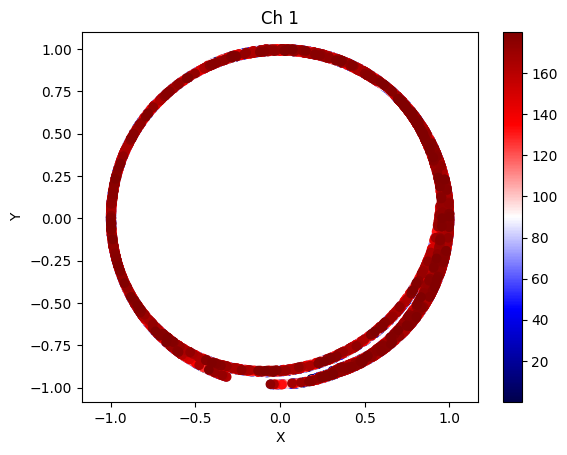

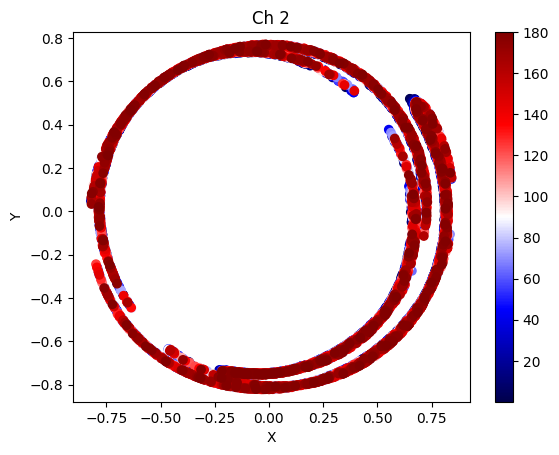

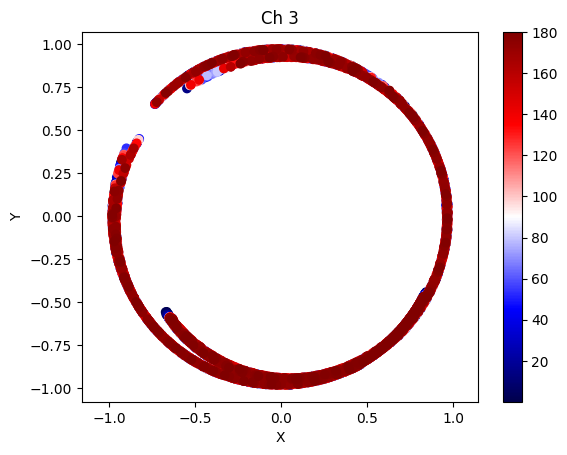

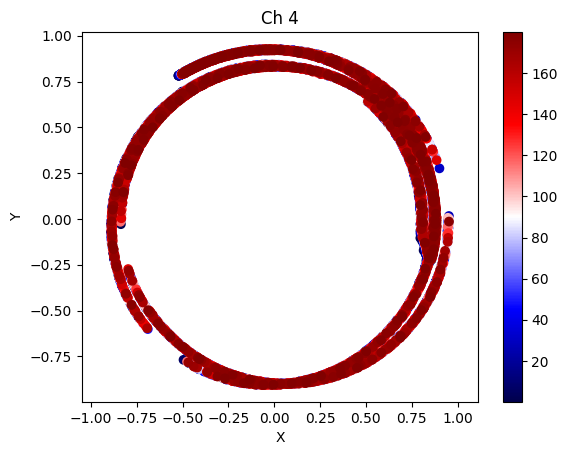

In [11]:

for i in range(4):
    chart = plt.figure()
    ax = chart.add_subplot(111)
    # Display data on 2D plot
    trace = ax.scatter(data[i,0], data[i,1], c=data[i,3], cmap='seismic', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Ch '+str(i+1))
    ax.set_aspect('equal', adjustable='datalim')
    plt.colorbar(trace)
    plt.show()

### Cambio di coordinate e plot con frequenza reale

Real freq: 0.9971485742871437Hz
Real freq: 0.9970485242621311Hz
Real freq: 0.9970485242621311Hz
Real freq: 0.9970485242621311Hz


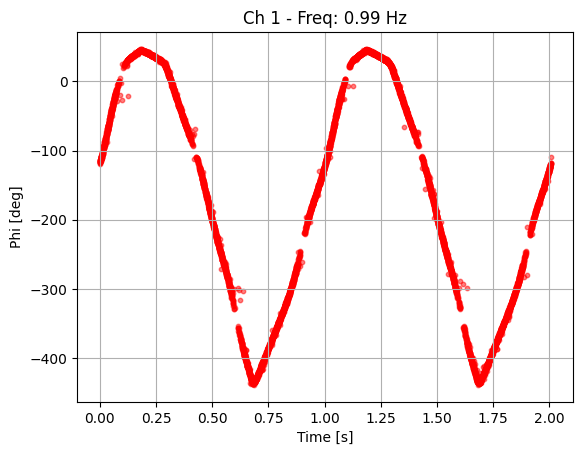

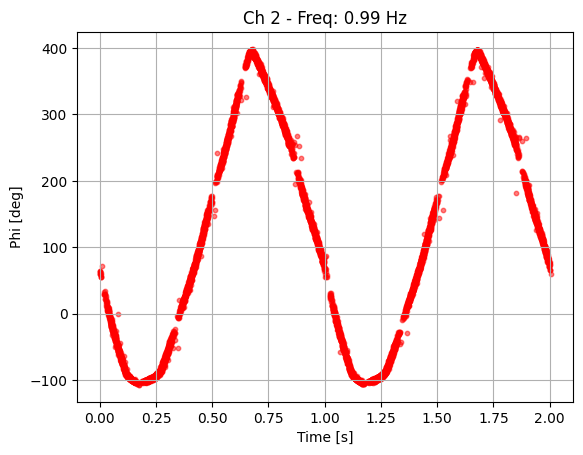

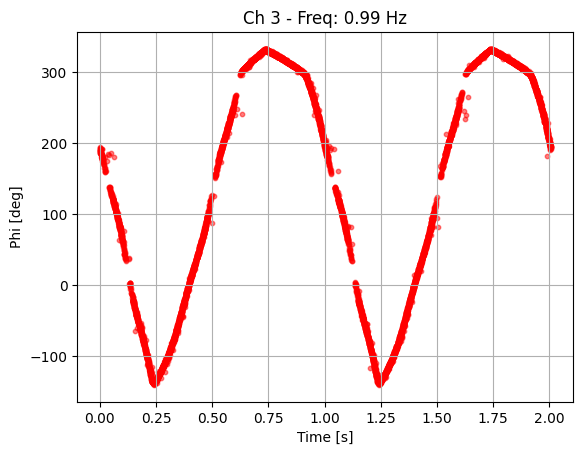

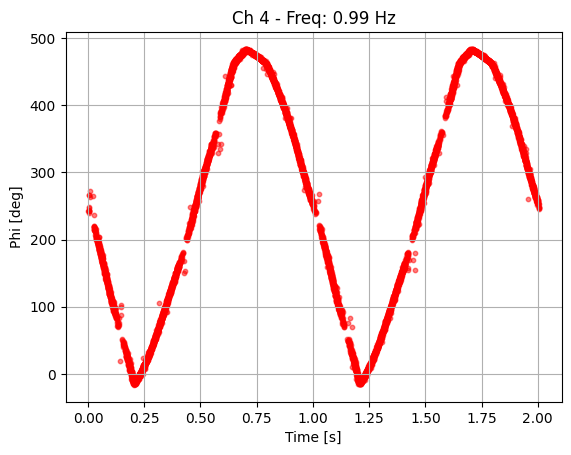

In [14]:
def get_freq(time_t, polar, i):
    freq = 1    # Frequenza settata (ideale)
    # Calcola il periodogramma
    f_test = np.linspace(freq-0.1, freq+0.1, 2000)
    omega = 2 * np.pi * f_test  # Lomb-Scargle usa pulsazioni

    # Calcola il periodogramma
    pgram = lombscargle(time_t[i], polar[i,1], omega, normalize=True)
    f = f_test[np.argmax(pgram)]  # Frequenza dominante
    return f


polar = np.empty((4,2), dtype=object)

for i in range(polar.shape[0]):
    for j in range(polar.shape[1]):
        polar[i, j] = []

time_t = np.empty((4), dtype=object)
for i in range(time_t.shape[0]):
    time_t[i] = []

chart1 = plt.figure()
c1 = chart1.add_subplot(111)
chart2 = plt.figure()
c2 = chart2.add_subplot(111)
chart3 = plt.figure()
c3 = chart3.add_subplot(111)
chart4 = plt.figure()
c4 = chart4.add_subplot(111)
ax =[c1, c2, c3, c4]

#offset = [0,1,1,-1,-1,0]
for i in range(4):
    """ lap=0
    if data[i,1][0]<0:
        lap=-1 """
    for j in range(0,len(data[i,0])):
        rho = np.sqrt(data[i,0][j]**2 + data[i,1][j]**2)
        phi = np.arctan2(data[i,1][j], data[i,0][j])

        """ if j>0 and data[i,1][j]<0 and data[i,1][j-1]>0 and (data[i,0][j-1]<0):
            #lap =+1
            lap +=1
        if j>0 and data[i,1][j]<0 and data[i,1][j-1]>0 and (data[i,0][j-1]>0):
            lap -=1
        if j>0 and data[i,1][j]>0 and data[i,1][j-1]<0 and (data[i,0][j-1]<0):
            #lap =-1
            lap -=1
        if j>0 and data[i,1][j]>0 and data[i,1][j-1]<0 and (data[i,0][j-1]>0):
            lap +=1
        phi= np.abs(phi+offset[lap%6]*2*np.pi)
        if lap<0:
            phi = -phi """
        #phi = np.degrees(phi)
        """ epsilon = 300           #200
        if j>0 and (phi - polar[i,1][-1:])<-(500-epsilon):
            phi += 360
        elif j>0 and (phi - polar[i,1][-1:])>(500-epsilon):
            phi -= 360 """
        polar[i,0].append(rho)
        polar[i,1].append(phi)
        time_t[i].append(data[i,3][j])
    
    polar[i,1]=np.unwrap(polar[i,1])
    polar[i,1]=np.degrees(polar[i,1])
    f = get_freq(time_t, polar, i)
    
    """ if(i==0):
        polar[i,1]=np.unwrap(polar[i,1])
        polar[i,1]=np.degrees(polar[i,1])
        f = get_freq(time_t, polar, i)
    else:
        f = get_freq(time_t, polar, i)
        polar[i,1]=np.unwrap(polar[i,1])
        polar[i,1]=np.degrees(polar[i,1]) """

    print("Real freq: "+str(f)+"Hz")
    time = np.empty(len(time_t[i]))
    for j in range(len(polar[i,1])):
        time[j] = time_t[i][j] % ((1/f)*2)
    points = -1                             #2Hz 885 points
    trace = ax[i].scatter(time[:points], polar[i,1][:points], c="r", marker='o', alpha=0.5, s=10)
    
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('Phi [deg]')
    ax[i].set_title('Ch '+str(i+1)+ r" - Freq: {:.2f} Hz".format(math.trunc(f*100)/100))
    ax[i].grid()
plt.show()
chart1.savefig("img/test3_1_final.pdf")
chart2.savefig("img/test3_2_final.pdf")
chart3.savefig("img/test3_3_final.pdf")
chart4.savefig("img/test3_4_final.pdf")